In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
EEG1_train = np.load('EEG1_train.npy')[:, 1:]
EEG2_train = np.load('EEG2_train.npy')[:, 1:]
EMG_train = np.load('EMG_train.npy')[:, 1:]
Y_train = np.load('Y_train.npy').astype(int)[:, 1]

EEG1_test = np.load('EEG1_test.npy')[:, 1:]
EEG2_test = np.load('EEG2_test.npy')[:, 1:]
EMG_test = np.load('EMG_test.npy')
test_ids = EMG_test[:, 0]
EMG_test = EMG_test[:, 1:]

EEG1_train.shape, EEG2_train.shape, EMG_train.shape

((64800, 512), (64800, 512), (64800, 512))

In [35]:
np.save('Y_train3.npy', Y_train)

In [38]:
(np.diff(Y_train) == 0).mean()

0.9610796462908379

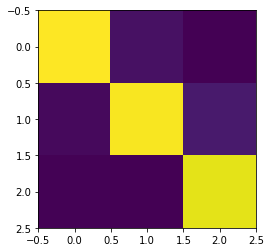

In [17]:
# Transition matrix
T = np.zeros((3, 3))

for i in range(1, len(Y_train)):
    if i % 21600 == 0: continue
    T[Y_train[i-1]-1, Y_train[i]-1] += 1

plt.imshow(T / T.sum(axis=1))

In [33]:
def autoreg_features(Y, window_size=5):
    Y_onehot = np.zeros((len(Y), 3))
    Y_onehot[[np.arange(len(Y)), Y-1]] = 1

    features = np.zeros((len(Y), window_size, 3))

    for i in range(len(Y)):
        for j in range(min(window_size, i)):
            features[i, j] = Y_onehot[i-j]

    return features.reshape((len(Y), -1))

ar = autoreg_features(Y_train)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
ar.shape

(64800, 15)

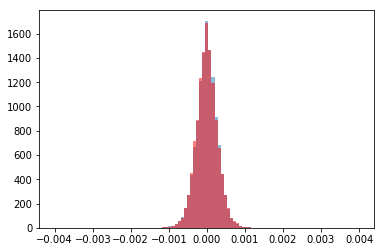

In [6]:
bins = np.linspace(-.004,.004, 100)
plt.hist(np.diff(EEG1_test).ravel(), bins, alpha=.5, density=True);
plt.hist(EEG1_test[:-1,-1] - EEG1_test[1:,0], bins, color='r', alpha=.5, density=True);

(array([435., 230., 203., 149., 120.,  97.,  70.,  63.,  74.,  67.,  56.,
         68.,  57.,  48.,  45.,  36.,  41.,  43.,  34.,  39.,  25.,  17.,
         28.,  29.,  32.,  22.,  11.,  14.,  22.,  12.,  11.,  14.,  22.,
         13.,   9.,  15.,   8.,  10.,   7.,   6.,   6.,  10.,   7.,   4.,
          5.,   1.,   3.,   1.,   5.,   6.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 <a list of 50 Patch objects>)

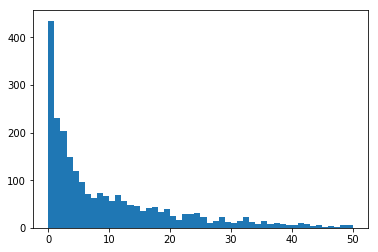

In [7]:
runlens = []
current, current_len = Y_train[0], 1

for y in Y_train[1:]:
    if y == current: current_len += 1
    else: 
        runlens.append(current_len)
        current, current_len = y, 0
        
plt.hist(runlens, bins=np.linspace(0, 50, 51))

# Ideas
  - Exploit continuity:
      - Join training data and cut random windows when consecutive labels are equal
      - In prediction?
      - Give more weight to signals in long runs
  - 

In [52]:
np.linspace(0,10,11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [54]:
EEG1_test.shape

(43200, 512)

In [56]:
X_train_features = np.load('jonathan/X_train3.npy')

In [69]:
def reslice(data, labels):
    # Extract runs
    run_data, run_labels = [], []
    current_label, current_run = labels[0], [data[0]]

    for data_slice, label in zip(data[1:], labels[1:]):
        if label == current_label:
            current_run.append(data_slice)
        else: 
            run_data.append(np.concatenate(current_run))
            run_labels.append(current_label)
            current_label, current_run = label, [data_slice]
    run_data.append(np.concatenate(current_run))
    run_labels.append(current_label)

    # Slice runs
    slice_length = data.shape[1]
    slices, slice_labels = [], []
    for data_slice, label in zip(run_data, run_labels):
        pos = 0
    
        while pos + slice_length <= len(data_slice):
            slices.append(data_slice[pos:pos + slice_length])
            slice_labels.append(label)
            pos += np.random.randint(slice_length // 4, slice_length // 2)
        
        if pos != len(data_slice):
            slices.append(data_slice[-slice_length:])
            slice_labels.append(label)
            
    return np.array(slices), np.array(labels)

In [75]:
sx, sy = reslice(np.stack((EEG1_train, EEG2_train, EMG_train), axis=2), Y_train)

In [80]:
np.all(test_ids.astype(int) == np.arange(len(test_ids)))

True

In [65]:
EEG1_train.shape

(64800, 512)